# PC4 · EDA & Visualización de Series Temporales (Rossmann · Tienda 6)


**Objetivo:** Entender el dataset y visualizarlo a fondo **antes** de hacer ingeniería de características o modelado.
Este notebook está pensado para trabajar con **datos diarios** de la Tienda 6 (Rossmann), con horizonte de predicción variable en el proyecto.
Incluye: carga y validación de datos, chequeos de calidad, análisis de granularidad, descomposición, **ACF/PACF**, **ADF/KPSS**, **STL**, **FFT** (periodicidad),
detección de outliers y visualizaciones clave.  
> **Nota:** Ajusta rutas, nombres de columnas y parámetros marcados como **TODO**.


## 0) Configuración & Librerías

In [36]:

# --- Configuración general ---
# TODO: Ajusta la ruta al CSV consolidado de la tienda 6
DATA_PATH = "data/df_tienda1_preprocesado.csv"

# Define aquí los nombres de columnas esperados (ajústalos a tu dataset real)
COL_DATE = "Date"
COL_TARGET = "Sales"           # variable objetivo
COL_OPEN = "Open"              # 0/1
COL_CUSTOMERS = "Customers-1lag"    # exógena (observada al final del día)
COL_DAYOFWEEK = "DayOfWeek"

# Otras posibles columnas exógenas/flags
CAND_EXOG = [
    "Promo", 
    "SchoolHoliday", 
    "StateHoliday_0", 
    "StateHoliday_a", 
    "StateHoliday_b", 
    "StateHoliay_c",
]

# Parámetros gráficos
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import signal

# Opcional: estilos
plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True

pd.options.display.max_columns = 100
pd.options.display.width = 140
sns.set_context("notebook")
print("Entorno listo.")


Entorno listo.


## 1) Carga, validación y saneamiento mínimo

In [38]:

# --- Carga de datos ---
df = pd.read_csv(DATA_PATH)

# Parseo de fecha
if not np.issubdtype(df[COL_DATE].dtype, np.datetime64):
    df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")

# Orden y set de índice temporal
df = df.sort_values(COL_DATE).reset_index(drop=True)
df = df.set_index(COL_DATE)

print("Rango temporal:", df.index.min(), "→", df.index.max(), "| Filas:", len(df))
display(df.head(3))
display(df.tail(3))

# Tipos y nulos
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False))


Rango temporal: 2013-01-01 00:00:00 → 2015-05-31 00:00:00 | Filas: 881


,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Customers-1lag
Date,,,,,,,,,,,
2013-01-01,2,0.0,0.0,0,0,0,0,0,1,1,781.0
2013-01-02,3,6089.0,781.0,1,0,0,1,1,1,1,689.0
2013-01-03,4,5398.0,689.0,1,0,1,1,1,1,1,724.0


,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Customers-1lag
Date,,,,,,,,,,,
2015-05-29,5,5435.0,612.0,1,0,1,1,1,1,1,394.0
2015-05-30,6,3756.0,394.0,1,0,1,1,1,1,1,0.0
2015-05-31,7,0.0,0.0,0,0,1,1,1,1,1,NaN


DayOfWeek           int64
Sales             float64
Customers         float64
Open                int64
Promo               int64
SchoolHoliday       int64
StateHoliday_0      int64
StateHoliday_a      int64
StateHoliday_b      int64
StateHoliday_c      int64
Customers-1lag    float64
dtype: object

Customers-1lag    1
DayOfWeek         0
Sales             0
Customers         0
Open              0
Promo             0
SchoolHoliday     0
StateHoliday_0    0
StateHoliday_a    0
StateHoliday_b    0
StateHoliday_c    0
dtype: int64

## 2) Sanity checks rápidos

In [40]:

assert df.index.is_monotonic_increasing, "El índice temporal no está ordenado."
assert COL_TARGET in df.columns, f"No está la columna objetivo '{COL_TARGET}'"
assert df.index.dtype == "datetime64[ns]", "El índice debe ser datetime."

# Chequeo de duplicados por fecha
dups = df.index.duplicated().sum()
print("Fechas duplicadas:", dups)

# Chequeo de gaps (faltantes de días)
full_range = pd.date_range(df.index.min(), df.index.max(), freq="D")
gaps = full_range.difference(df.index)
print("Número de días ausentes:", len(gaps))
if len(gaps) > 0:
    print("Ejemplos de gaps:", gaps[:10])


Fechas duplicadas: 0
Número de días ausentes: 0


## 3) Resumen estadístico y distribución del objetivo

,Sales
count,881.000000
mean,4598.876277
std,2558.973283
min,0.000000
1%,0.000000
5%,0.000000
25%,3411.000000
50%,5079.000000
75%,6389.000000
95%,8085.000000


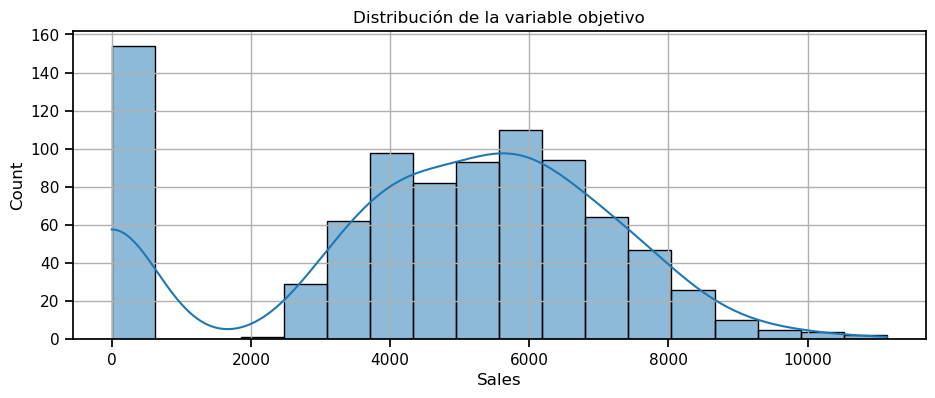

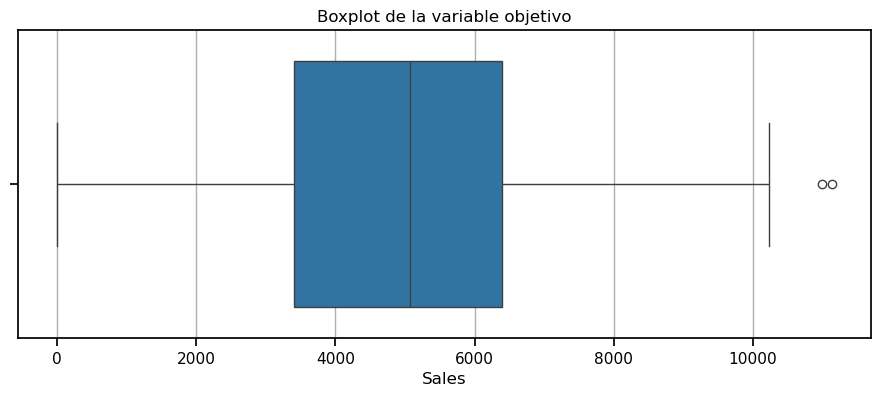

In [42]:

display(df[[COL_TARGET]].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

fig, ax = plt.subplots()
sns.histplot(df[COL_TARGET].dropna(), kde=True, ax=ax)
ax.set_title("Distribución de la variable objetivo")
plt.show()

fig, ax = plt.subplots()
sns.boxplot(x=df[COL_TARGET].dropna(), ax=ax)
ax.set_title("Boxplot de la variable objetivo")
plt.show()


## 4) Visualización temporal básica y agregaciones

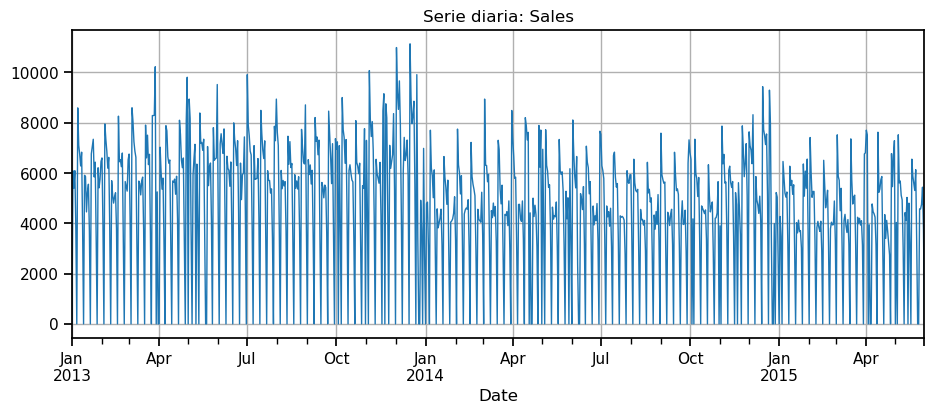

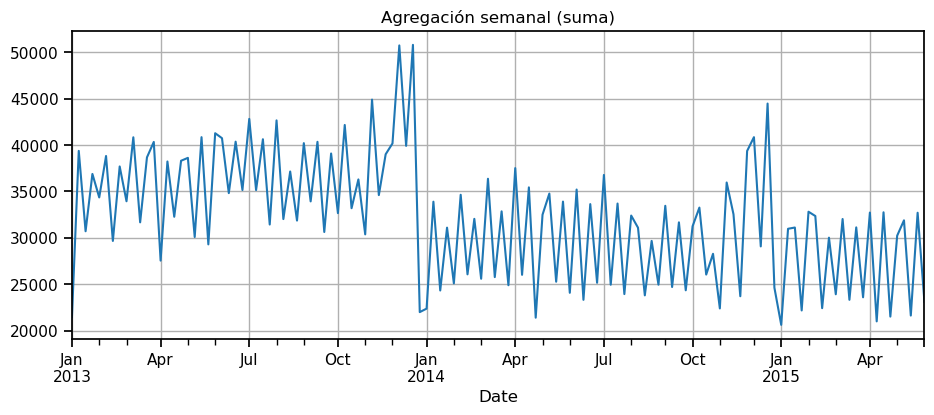

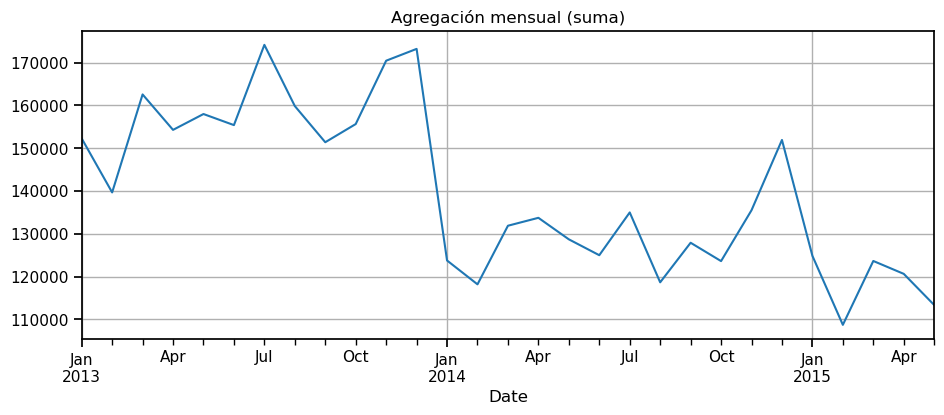

In [44]:

fig, ax = plt.subplots()
df[COL_TARGET].plot(ax=ax, lw=1)
ax.set_title(f"Serie diaria: {COL_TARGET}")
plt.show()

# Agregaciones semanales y mensuales (suma)
weekly = df[COL_TARGET].resample("W").sum()
monthly = df[COL_TARGET].resample("M").sum()

fig, ax = plt.subplots()
weekly.plot(ax=ax)
ax.set_title("Agregación semanal (suma)")
plt.show()

fig, ax = plt.subplots()
monthly.plot(ax=ax)
ax.set_title("Agregación mensual (suma)")
plt.show()


### De estas 3 gráficas podemos ver que el comportamiento para hacer pronóstico diariamente será complicado, pero es lo primero que intentaremos, los siguiente será probarlo semanalmente.

## 5) Features de calendario (para diagnóstico, no modelado todavía)

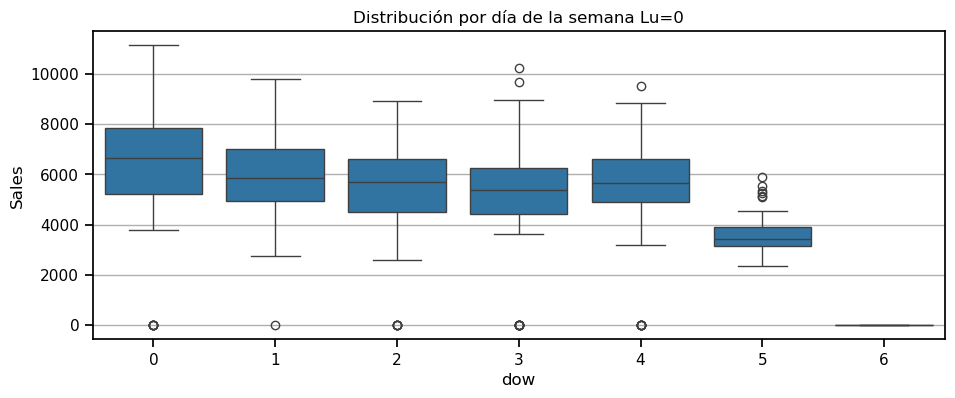

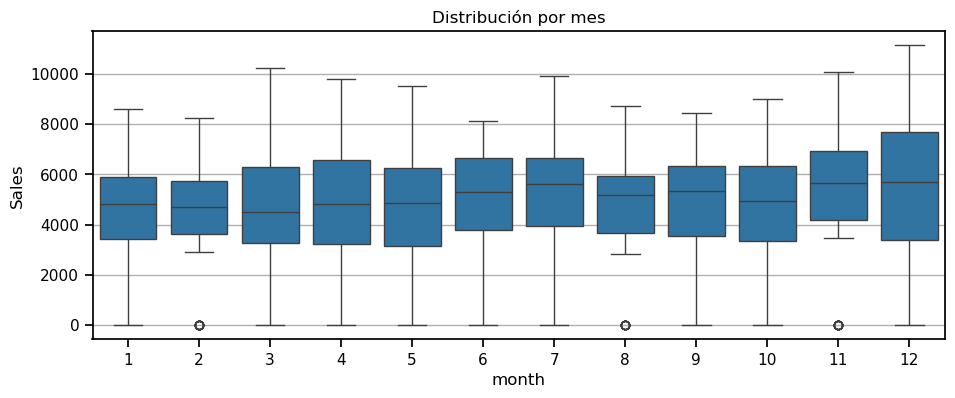

In [47]:

# Generamos algunas columnas temporales para detectar patrones
tmp = df.copy()
tmp["dow"] = tmp.index.dayofweek  # 0=Lunes
tmp["week"] = tmp.index.isocalendar().week.astype(int)
tmp["month"] = tmp.index.month
tmp["year"] = tmp.index.year

fig, ax = plt.subplots()
sns.boxplot(data=tmp, x="dow", y=COL_TARGET, ax=ax)
ax.set_title("Distribución por día de la semana Lu=0")
plt.show()

fig, ax = plt.subplots()
sns.boxplot(data=tmp, x="month", y=COL_TARGET, ax=ax)
ax.set_title("Distribución por mes")
plt.show()


## 6) Revisión de variables **Open** y **Customers** (relación con ventas)

Columnas presentes: ['Open', 'Customers-1lag']


,count,mean,std,min,25%,50%,75%,max
Open,,,,,,,,
0,154.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,727.0,5573.053645,1581.381072,2355.0,4287.5,5553.0,6626.5,11139.0


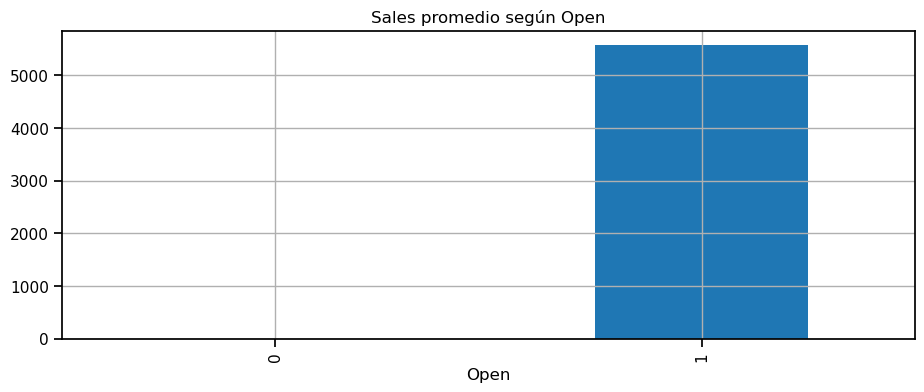

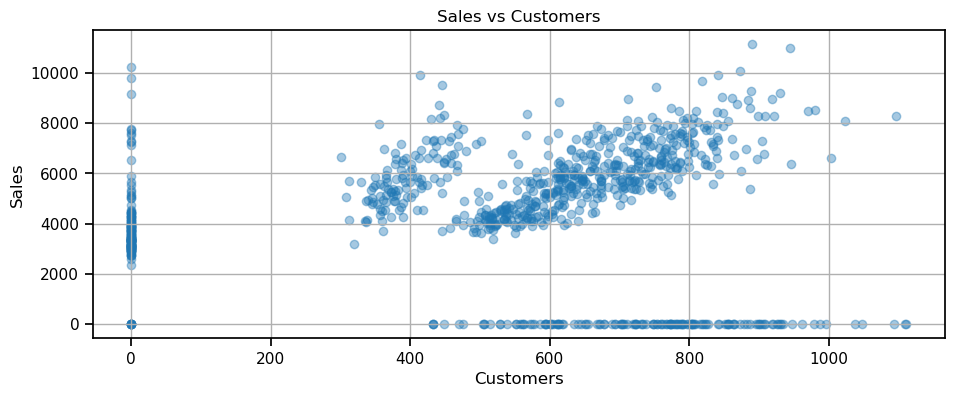

In [49]:

cols_exist = [c for c in [COL_OPEN, COL_CUSTOMERS] if c in df.columns]
print("Columnas presentes:", cols_exist)

if COL_OPEN in df.columns:
    pivot_open = df.groupby(df[COL_OPEN])[COL_TARGET].describe()
    display(pivot_open)

    fig, ax = plt.subplots()
    df.groupby(df[COL_OPEN])[COL_TARGET].mean().plot(kind="bar", ax=ax)
    ax.set_title("Sales promedio según Open")
    plt.show()

if COL_CUSTOMERS in df.columns:
    fig, ax = plt.subplots()
    ax.scatter(df[COL_CUSTOMERS], df[COL_TARGET], alpha=0.4)
    ax.set_xlabel("Customers")
    ax.set_ylabel("Sales")
    ax.set_title("Sales vs Customers")
    plt.show()


## 7) Detección de outliers (IQR / Z-score) — *solo diagnóstico*

IQR= 2978.00 | Umbrales: < -1056.00 o > 10856.00 | N outliers: 2


Date
2013-12-02    10992.0
2013-12-16    11139.0
Name: Sales, dtype: float64

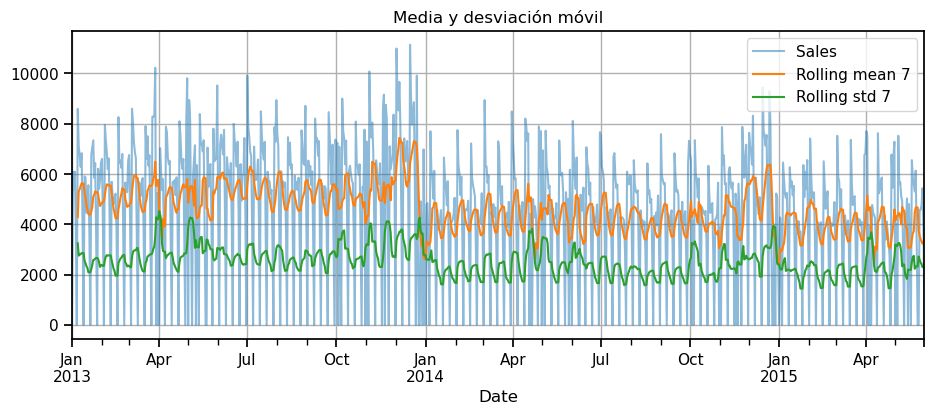

In [51]:

q1, q3 = df[COL_TARGET].quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = df[(df[COL_TARGET] < low) | (df[COL_TARGET] > high)][COL_TARGET]
print(f"IQR= {iqr:.2f} | Umbrales: < {low:.2f} o > {high:.2f} | N outliers: {outliers.shape[0]}")
display(outliers.head())

# Visualización rolling mean/std
roll_w = 7  # TODO: ajustar
fig, ax = plt.subplots()
df[COL_TARGET].plot(ax=ax, alpha=0.5, label="Sales")
df[COL_TARGET].rolling(roll_w).mean().plot(ax=ax, label=f"Rolling mean {roll_w}")
df[COL_TARGET].rolling(roll_w).std().plot(ax=ax, label=f"Rolling std {roll_w}")
ax.legend()
ax.set_title("Media y desviación móvil")
plt.show()


### De esta gráfica vemos que no es recomendable hacer una forcast diario, porque tenemos muchos ruido, no hay tendencias claros y además no hay estabilidad.
También vemos dos valores extremos que los vamos a dejar porque es posible que en navidades se hayan tenido picos de ventas.

## 8) ACF y PACF (autocorrelación)

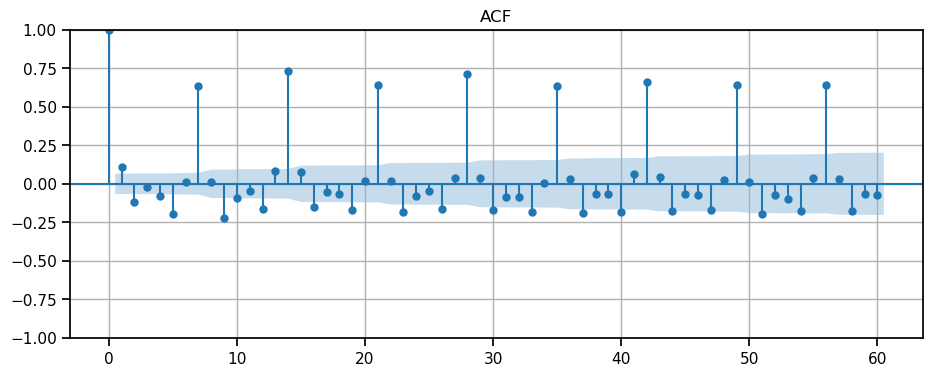

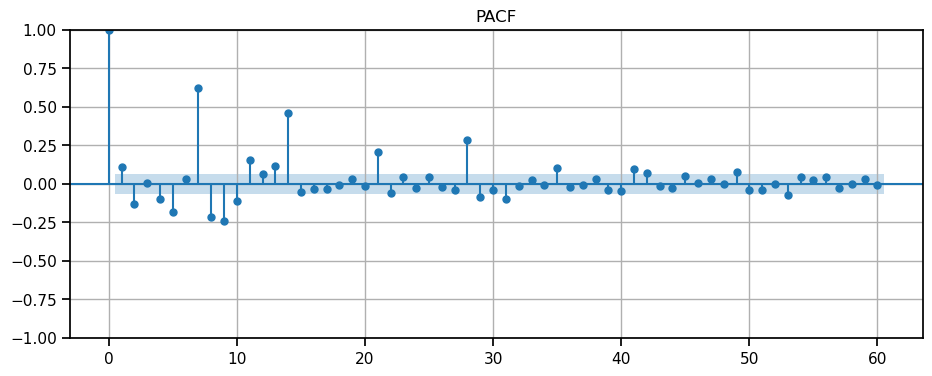

In [54]:

max_lag = 60  # TODO: ajustar según ventana/horizonte
fig = plot_acf(df[COL_TARGET].dropna(), lags=max_lag)
plt.title("ACF")
plt.show()

fig = plot_pacf(df[COL_TARGET].dropna(), lags=max_lag, method="ywm")
plt.title("PACF")
plt.show()


### Conclusiones
**ACF (Autocorrelation Function) 
-Muestra cómo la serie se relaciona consigo misma en diferentes retrasos (lags).
-Los picos más fuertes aparecen en intervalos regulares (alrededor de 7, 14, 21, 28, …).
-Eso indica una estacionalidad semanal clara: las ventas tienden a repetirse con un patrón cada 7 días.
-Fuera de esos múltiplos, la mayoría de las barras están dentro del intervalo azul (no significativas).

**PACF (Partial Autocorrelation Function)
+Muestra la relación de la serie con cada retraso, eliminando la influencia de los intermedios.
+En tu gráfico, los picos más importantes están en lag 1 (fuerte dependencia inmediata), y también en lag 7 (confirmando la estacionalidad semanal).
+Después, las correlaciones caen y se mantienen bajas, sin patrones fuertes.

**Conclusión:
Lag 1 > lo que pasa hoy depende mucho de lo que pasó ayer, por eso vamos a tener Customer-1lag para obtener información.
Lag 7 > las ventas de hoy también se parecen bastante a las de hace una semana

## 9) Estacionariedad: ADF y KPSS

In [57]:

def adf_test(x):
    res = adfuller(x.dropna(), autolag='AIC')
    out = {"ADF Statistic": res[0], "p-value": res[1], "lags": res[2], "nobs": res[3]}
    return out

def kpss_test(x, regression='c'):
    res = kpss(x.dropna(), regression=regression, nlags="auto")
    out = {"KPSS Statistic": res[0], "p-value": res[1], "lags": res[2]}
    return out

print("ADF:", adf_test(df[COL_TARGET]))
print("KPSS:", kpss_test(df[COL_TARGET], regression='c'))  # 'c' constante; 'ct' constante+trend


ADF: {'ADF Statistic': -3.1664213464765774, 'p-value': 0.022012491338061, 'lags': 21, 'nobs': 859}
KPSS: {'KPSS Statistic': 3.0752692578465433, 'p-value': 0.01, 'lags': 13}


### Conclusiones
* ADF p-value =0.002 < 0.05 Rechazamos la hipótesis nula. Esto significa que según el test la serie es estacionaria (al menos en nivel, sin diferenciar)
* KPSS p-value = 0-001 muy bajo, la serie NO es estacionaria

## 10) Descomposición STL (tendencia, estacionalidad, residuo)

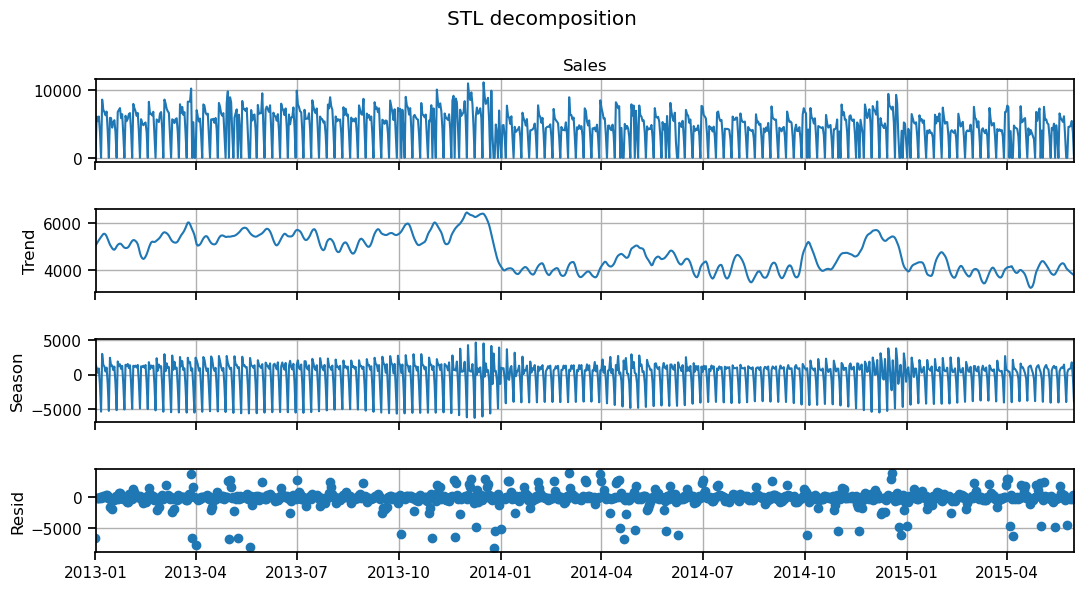

In [60]:

# TODO: ajustar el periodo estacional. Para datos diarios con estacionalidad semanal ~7
seasonal_period = 7
stl = STL(df[COL_TARGET].dropna(), period=seasonal_period, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(11, 6)
fig.suptitle("STL decomposition", y=1.02)
plt.show()


## 11) Transformada de Fourier (FFT) y periodograma — detectar periodicidades

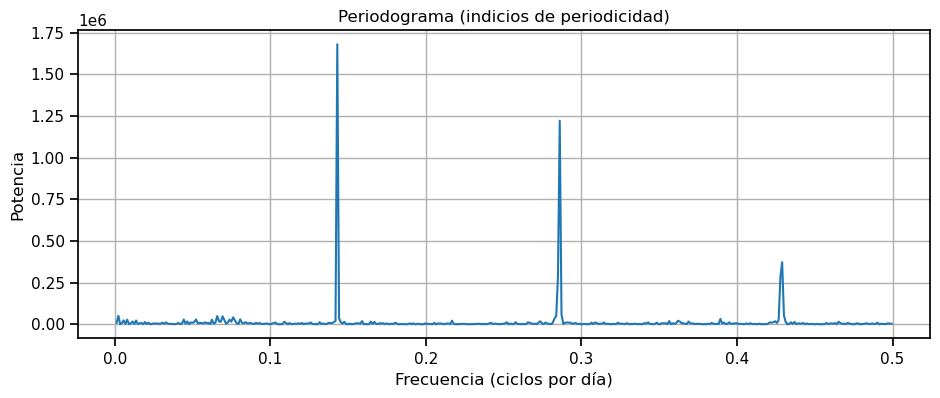

,period_days,power
0,6.99,1.680133e+06
1,3.50,1.221446e+06
2,2.33,3.724340e+05
3,3.51,2.861569e+05
4,2.34,2.838446e+05


In [62]:

y = df[COL_TARGET].fillna(method="ffill").values  # forward-fill simple para FFT
fs = 1.0  # 1 muestra/día
f, Pxx = signal.periodogram(y, fs=fs, detrend="linear", scaling="spectrum")

# Evitar el componente DC (frecuencia 0)
mask = f > 0
f, Pxx = f[mask], Pxx[mask]

fig, ax = plt.subplots()
ax.plot(f, Pxx)
ax.set_xlabel("Frecuencia (ciclos por día)")
ax.set_ylabel("Potencia")
ax.set_title("Periodograma (indicios de periodicidad)")
plt.show()

# Convertimos frecuencias a periodos (días por ciclo)
periods = 1 / f
top_idx = np.argsort(Pxx)[-5:][::-1]
top_periods = periods[top_idx]
top_power = Pxx[top_idx]
import pandas as pd
pd.DataFrame({"period_days": np.round(top_periods,2), "power": top_power}).reset_index(drop=True)


### Conclusiones
* La transformada confirma que hay fuerte señales cada 7 días, cada 3.5 y cada 2.33, algo así ya sabíamos de la autocorrelación.

## 12) Correlaciones y lag plots con exógenas (diagnóstico)

Sales             1.000000
Open              0.827610
Promo             0.599143
StateHoliday_0    0.308825
StateHoliday_a    0.238999
StateHoliday_b    0.148903
Customers-1lag    0.094710
SchoolHoliday    -0.070254
Name: Sales, dtype: float64

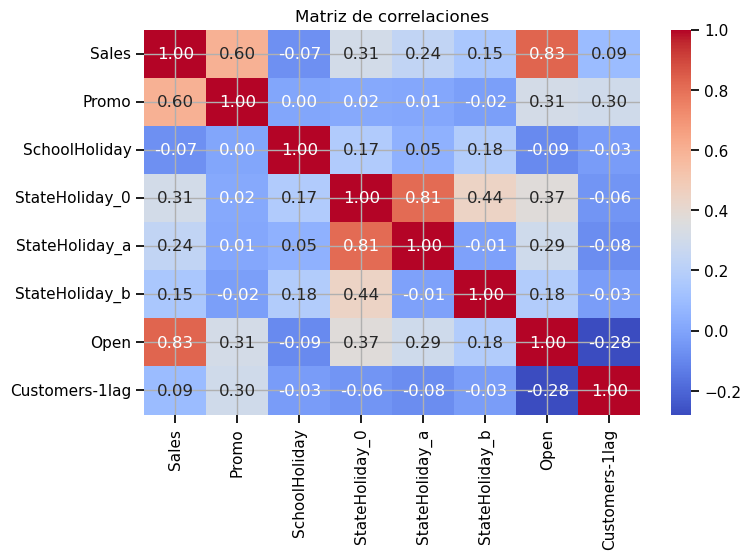

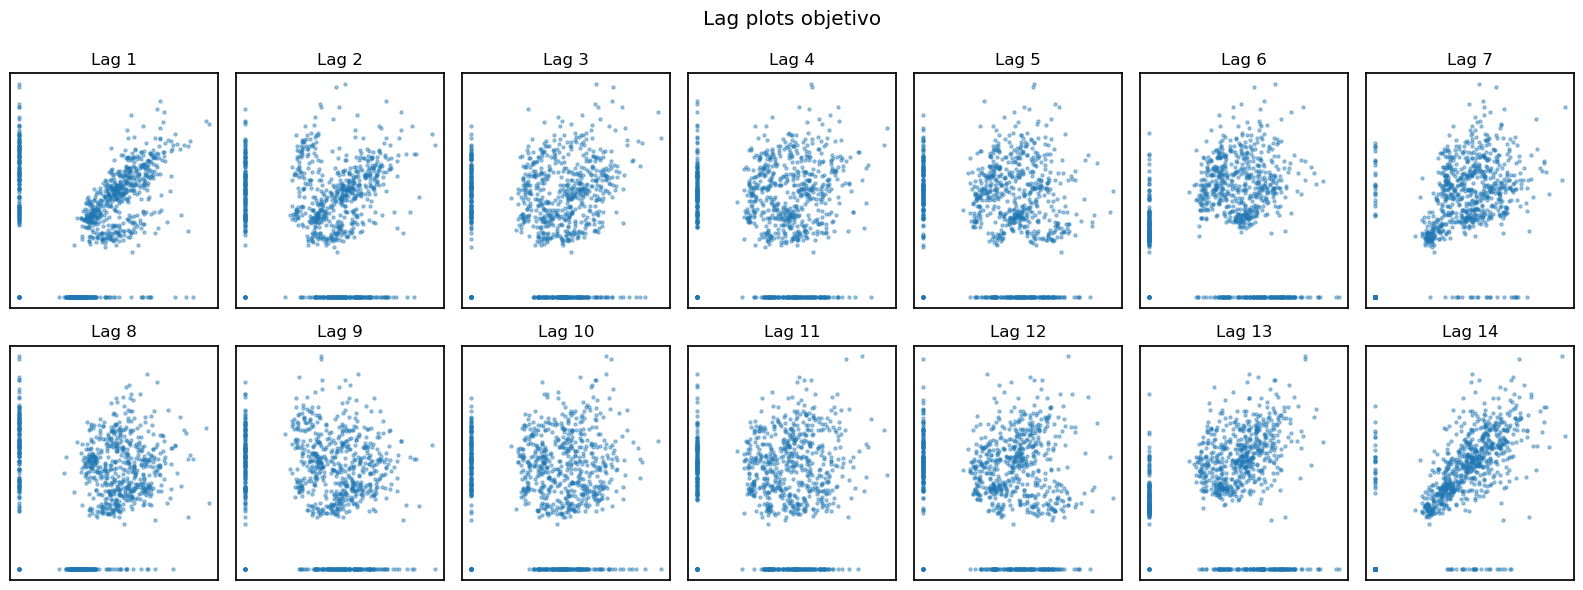

In [65]:

# Correlación simple (Pearson) con exógenas disponibles
exogs = [c for c in CAND_EXOG + [COL_OPEN, COL_CUSTOMERS] if c in df.columns and c != COL_TARGET]
if exogs:
    corr_df = df[[COL_TARGET] + exogs].corr()
    display(corr_df[COL_TARGET].sort_values(ascending=False))

    # Heatmap
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
    ax.set_title("Matriz de correlaciones")
    plt.show()

# Lag plots del objetivo (autodependencia visual)
max_lag_plot = 14  # TODO
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(16,6))
axes = axes.flatten()
for lag in range(1, max_lag_plot+1):
    axes[lag-1].scatter(df[COL_TARGET].shift(lag), df[COL_TARGET], s=5, alpha=0.4)
    axes[lag-1].set_title(f"Lag {lag}")
    axes[lag-1].set_xticks([]); axes[lag-1].set_yticks([])
plt.suptitle("Lag plots objetivo")
plt.tight_layout()
plt.show()


### Conclusiones
** De la correlación podemos pensar en quedarnos en un futuro con tres variables Promo, Open y Customers-1lag
** En cuanto a los lag, el que parece más evidente es el de 14 días y el de -día.

## 13) Estabilidad local: medias/varianzas por ventanas

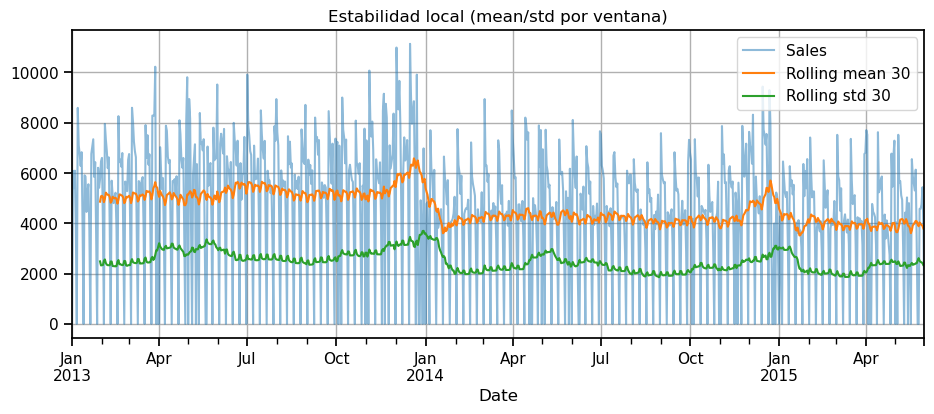

In [68]:

win = 30  # TODO
ts = df[COL_TARGET].dropna()
rolling_mean = ts.rolling(win).mean()
rolling_std = ts.rolling(win).std()

fig, ax = plt.subplots()
ts.plot(ax=ax, alpha=0.5, label="Sales")
rolling_mean.plot(ax=ax, label=f"Rolling mean {win}")
rolling_std.plot(ax=ax, label=f"Rolling std {win}")
ax.legend()
ax.set_title("Estabilidad local (mean/std por ventana)")
plt.show()


### Conclusiones
1. Rolling Mean (línea naranja)
Se observa que la media no es constante a lo largo del tiempo.
Hay periodos donde la media sube (ej. alrededor de principios de 2014) y otros donde baja (mediados de 2014 y después de 2015).
Esto confirma que la serie tiene tendencia y cambios estructurales en diferentes momentos.
2. Rolling Std (línea verde)
La volatilidad (variabilidad de las ventas) también cambia con el tiempo.
Hay momentos de mayor dispersión (ej. en picos de ventas o temporadas altas) y otros más estables.
No es constante, lo que significa que la varianza tampoco es estacionaria.

## Será necesario aplicar alguna transformación (diferenciación, logaritmo, Box-Cox o estandarización) antes de modelar.
Para ARIMA → d=1 y D=1 con s=7 siguen siendo buenos candidatos.

Para LSTM → un escalado (MinMaxScaler/StandardScaler) y quizá usar ventanas temporales que capten los cambios locales.

## 14) Checklist para pasar a Feature Engineering y Preprocesado


- [ ] Columnas y tipos validados.  
- [ ] Gaps temporales resueltos (relleno o exclusión justificada).  
- [ ] Outliers caracterizados (no necesariamente eliminados aún).  
- [ ] Periodicidades principales identificadas (ACF/PACF/FFT).  
- [ ] Estacionalidad y tendencia analizadas (STL).  
- [ ] Variables exógenas entendidas (Open, Customers, Promo, etc.).  
- [ ] Decisiones sobre escalas y normalización **pendientes** para el siguiente notebook.  
- [ ] Definición del horizonte (p.ej., 30 días) y ventana temporal candidata para el modelado.  


## 15) Apéndice: utilidades (helpers opcionales)

In [73]:

def summarize_nulls(dataframe, top=20):
    s = dataframe.isna().sum().sort_values(ascending=False)
    return s[s>0].head(top)

def weekday_name(idx):
    return ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"][idx]

print("Helpers listos.")


Helpers listos.
